# tf2_拓展

## 本讲目标：学会神经网络优化过程，使用正则化减少过拟合，使用优化器更新网络参数
### •预备知识
### •神经网络复杂度
### •指数衰减学习率（略）
### •激活函数（略）
### •损失函数
### •欠拟合与过拟合
### •正则化减少过拟合
### •优化器更新网络参数

# 1、预备知识
### （1）条件语句真返回A，条件语句假返回B
### tf.where(条件语句，真返回A，假返回B)

In [1]:
import tensorflow as tf
a=tf.constant([1,2,3,1,1])
b=tf.constant([0,1,3,4,5])
c=tf.where(tf.greater(a,b), a, b) # 若a>b，返回a对应位置的元素，否则返回b对应位置的元素
print("c:",c)

c: tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)


### （2）np.random.RandomState.rand()
### 返回一个[0,1)之间的随机数
### np.random.RandomState.rand(维度) #维度为空，返回标量

In [2]:
import numpy as np
rdm=np.random.RandomState(seed=1) #seed=常数每次生成随机数相同
a=rdm.rand() # 返回一个随机标量
b=rdm.rand(2,3) # 返回维度为2行3列随机数矩阵
print("a:",a)
print("b:",b)

a: 0.417022004702574
b: [[7.20324493e-01 1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02 1.86260211e-01]]


### （3）np.vstack()
### 将两个数组按垂直方向叠加
### np.vstack(数组1，数组2)

In [3]:
a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.vstack((a,b))
print("c:\n",c)

c:
 [[1 2 3]
 [4 5 6]]


### （4）np.mgrid[ ] .ravel( ) np.c_[ ]
### ——np.mgrid[ ] 返
### np.mgrid[ 起始值: 结束值: 步长，起始值: 结束值: 步长, … ]

### ——x.ravel( ) 将x变为一维数组，“把.前变量拉直”

### ——np.c_[ ]使返回的间隔数值点配对
### np.c_[ 数组1，数组2，… ]

In [4]:
x, y = np.mgrid[1:3:1, 2:4:0.5]
grid = np.c_[x.ravel(), y.ravel()]
print("x:",x)
print("y:",y)
print('grid:\n', grid)

x: [[1. 1. 1. 1.]
 [2. 2. 2. 2.]]
y: [[2.  2.5 3.  3.5]
 [2.  2.5 3.  3.5]]
grid:
 [[1.  2. ]
 [1.  2.5]
 [1.  3. ]
 [1.  3.5]
 [2.  2. ]
 [2.  2.5]
 [2.  3. ]
 [2.  3.5]]


# 2、神经网络（NN）复杂度
## ——NN复杂度：多用NN层数和NN参数的个数表示

## ——空间复杂度：
### 层数= 隐藏层的层数+ 1个输出层
### 总参数= 总w + 总b

## ——时间复杂度：
### 乘加运算次数

# 3、损失函数
### NN优化目标：loss最小
### （1）mse (Mean Squared Error)
### loss_mse = tf.reduce_mean(tf.square(y_ -y))

#### 预测酸奶日销量y，x1、x2是影响日销量的因素。建模前，应预先采集的数据有：每日x1、x2和销量y_（即已知答案，最佳情况：产量=销量）拟造数据集X,Y_：y_ = x1 + x2 噪声：-0.05 ~ +0.05 拟合可以预测销量的函数

In [5]:
import tensorflow as tf
import numpy as np

SEED = 23455

rdm = np.random.RandomState(seed=SEED)  # 生成[0,1)之间的随机数
x = rdm.rand(32, 2)
y_ = [[x1 + x2 + (rdm.rand() / 10.0 - 0.05)] for (x1, x2) in x]  # 生成噪声[0,1)/10=[0,0.1); [0,0.1)-0.05=[-0.05,0.05)
x = tf.cast(x, dtype=tf.float32)

w1 = tf.Variable(tf.random.normal([2, 1], stddev=1, seed=1))

epoch = 15000
lr = 0.002

for epoch in range(epoch):
    with tf.GradientTape() as tape:
        y = tf.matmul(x, w1)
        loss_mse = tf.reduce_mean(tf.square(y_ - y))

    grads = tape.gradient(loss_mse, w1)
    w1.assign_sub(lr * grads)

    if epoch % 10000 == 0:
        print("After %d training steps,w1 is " % (epoch))
        print(w1.numpy(), "\n")
print("Final w1 is: ", w1.numpy())

After 0 training steps,w1 is 
[[-0.8096241]
 [ 1.4855157]] 

After 10000 training steps,w1 is 
[[0.9801975]
 [1.0159837]] 

Final w1 is:  [[1.0009792]
 [0.9977485]]


### （2 ）自定义损失函数
### 如预测商品销量，预测多了，损失成本；预测少了，损失利润。
### 若利润不等于成本，则mse产生的loss无法利益最大化

####  自定义损失函数 酸奶成本1元， 酸奶利润99元。成本很低，利润很高，人们希望多预测些，生成模型系数大于1，往多了预测

In [6]:
import tensorflow as tf
import numpy as np

SEED = 23455
COST = 1
PROFIT = 99

rdm = np.random.RandomState(SEED)
x = rdm.rand(32, 2)
y_ = [[x1 + x2 + (rdm.rand() / 10.0 - 0.05)] for (x1, x2) in x]  # 生成噪声[0,1)/10=[0,0.1); [0,0.1)-0.05=[-0.05,0.05)
x = tf.cast(x, dtype=tf.float32)

w1 = tf.Variable(tf.random.normal([2, 1], stddev=1, seed=1))

epoch = 10000
lr = 0.002

for epoch in range(epoch):
    with tf.GradientTape() as tape:
        y = tf.matmul(x, w1)
        loss = tf.reduce_sum(tf.where(tf.greater(y, y_), (y - y_) * COST, (y_ - y) * PROFIT))

    grads = tape.gradient(loss, w1)
    w1.assign_sub(lr * grads)

    if epoch % 4000 == 0:
        print("After %d training steps,w1 is " % (epoch))
        print(w1.numpy(), "\n")
print("Final w1 is: ", w1.numpy())

# 自定义损失函数
# 酸奶成本1元， 酸奶利润99元
# 成本很低，利润很高，人们希望多预测些，生成模型系数大于1，往多了预测

After 0 training steps,w1 is 
[[2.8786578]
 [3.2517848]] 

After 4000 training steps,w1 is 
[[1.1751455]
 [1.1323601]] 

After 8000 training steps,w1 is 
[[1.1151826]
 [1.0409834]] 

Final w1 is:  [[1.1255957]
 [1.0237043]]


### （3）交叉熵损失函数CE (Cross Entropy)
### 表征两个概率分布之间的距离 tf.losses.categorical_crossentropy(y_，y)

In [7]:
loss_ce1=tf.losses.categorical_crossentropy([1,0],[0.6,0.4])
loss_ce2=tf.losses.categorical_crossentropy([1,0],[0.8,0.2])
print("loss_ce1:", loss_ce1)
print("loss_ce2:", loss_ce2)

loss_ce1: tf.Tensor(0.5108256, shape=(), dtype=float32)
loss_ce2: tf.Tensor(0.22314353, shape=(), dtype=float32)


### （4）softmax与交叉熵结合
### 输出先过softmax函数，再计算y与y_的交叉熵损失函数。
### tf.nn.softmax_cross_entropy_with_logits(y_，y)

In [8]:
y_ = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]])
y = np.array([[12, 3, 2], [3, 10, 1], [1, 2, 5], [4, 6.5, 1.2], [3, 6, 1]])
y_pro= tf.nn.softmax(y)
loss_ce1 = tf.losses.categorical_crossentropy(y_, y_pro)
loss_ce2 = tf.nn.softmax_cross_entropy_with_logits(y_, y)
print('分步计算的结果:\n', loss_ce1)
print('结合计算的结果:\n', loss_ce2)

分步计算的结果:
 tf.Tensor(
[1.68795487e-04 1.03475622e-03 6.58839038e-02 2.58349207e+00
 5.49852354e-02], shape=(5,), dtype=float64)
结合计算的结果:
 tf.Tensor(
[1.68795487e-04 1.03475622e-03 6.58839038e-02 2.58349207e+00
 5.49852354e-02], shape=(5,), dtype=float64)


# 4、欠拟合和过拟合

### ——欠拟合的解决方法：
#### 增加输入特征项
#### 增加网络参数
#### 减少正则化参数

### ——过拟合的解决方法：
#### 数据清洗
#### 增大训练集
#### 采用正则化
#### 增大正则化参数

# 5、正则化缓解过拟合
### 正则化在损失函数中引入模型复杂度指标，利用给W加权值，弱化了训练数据的噪声（一般不正则化b）
### loss = loss( y与y_ )+ REGULARIZER * loss(w)

### 正则化的选择
#### L1正则化大概率会使很多参数变为零，因此该方法可通过稀疏参数，即减少参数的数量，降低复杂度。
#### L2正则化会使参数很接近零但不为零，因此该方法可通过减小参数值的大小降低复杂度。

## （1）未正则化处理

epoch: 0 loss: 0.39009323716163635
epoch: 100 loss: 0.03267413005232811
epoch: 200 loss: 0.028198162093758583
epoch: 300 loss: 0.02499411068856716
*******predict*******


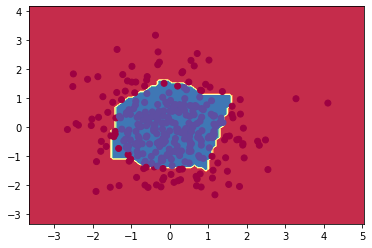

In [12]:
# 导入所需模块
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# 读入数据/标签 生成x_train y_train
df = pd.read_csv('dot.csv')
x_data = np.array(df[['x1', 'x2']])
y_data = np.array(df['y_c'])

x_train = np.vstack(x_data).reshape(-1,2)
y_train = np.vstack(y_data).reshape(-1,1)
Y = y_train

Y_c = [['red' if y else 'blue'] for y in y_train]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型问题报错
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)

# from_tensor_slices函数切分传入的张量的第一个维度，生成相应的数据集，使输入特征和标签值一一对应
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

# 生成神经网络的参数，输入层为2个神经元，隐藏层为11个神经元，1层隐藏层，输出层为1个神经元
# 用tf.Variable()保证参数可训练
w1 = tf.Variable(tf.random.normal([2, 11]), dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01, shape=[11]))

w2 = tf.Variable(tf.random.normal([11, 1]), dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01, shape=[1]))

lr = 0.01  # 学习率
epoch = 400  # 循环轮数

# 训练部分
for epoch in range(epoch):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:  # 记录梯度信息

            h1 = tf.matmul(x_train, w1) + b1  # 记录神经网络乘加运算
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1, w2) + b2

            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss = tf.reduce_mean(tf.square(y_train - y))

        # 计算loss对各个参数的梯度
        variables = [w1, b1, w2, b2]
        grads = tape.gradient(loss, variables)

        # 实现梯度更新
        # w1 = w1 - lr * w1_grad tape.gradient是自动求导结果与[w1, b1, w2, b2] 索引为0，1，2，3 
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])

    # 每20个epoch，打印loss信息
    if epoch % 100 == 0:
        print('epoch:', epoch, 'loss:', float(loss))

        
# 预测绘图
print("*******predict*******")
# xx在-3到3之间以步长为0.01，yy在-3到3之间以步长0.01,生成间隔数值点
x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
xx, yy = np.mgrid[x_min:x_max:.1, y_min:y_max :.1]
# 将xx , yy拉直，并合并配对为二维张量，生成二维坐标点
grid = np.c_[xx.ravel(), yy.ravel()]
grid = tf.cast(grid, tf.float32)

h1 = tf.matmul(grid, w1) + b1
h1 = tf.nn.relu(h1)
probs = tf.matmul(h1, w2) + b2  # y为预测结果
# 取第0列给x1，取第1列给x2
x1 = x_data[:, 0]
x2 = x_data[:, 1]
p = np.zeros((probs.shape[0],1))
for i in range(0, probs.shape[0]):
        if probs[i,0] > 0.5:
            p[i,0] = 1
        else:
            p[i,0] = 0
p = p.reshape(xx.shape)
plt.contourf(xx, yy, p, cmap=plt.cm.Spectral)
plt.scatter(x1, x2, c= Y, cmap=plt.cm.Spectral) 
plt.show()

## （2）正则化处理
### 只对loss函数做了改变，其余皆不变

epoch: 0 loss: 1.999328374862671
epoch: 100 loss: 0.277663916349411
epoch: 200 loss: 0.1708734780550003
epoch: 300 loss: 0.11429345607757568
*******predict*******


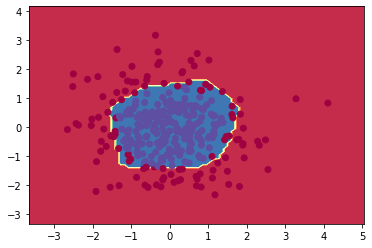

In [13]:
# 导入所需模块
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# 读入数据/标签 生成x_train y_train
df = pd.read_csv('dot.csv')
x_data = np.array(df[['x1', 'x2']])
y_data = np.array(df['y_c'])

x_train = x_data
y_train = y_data.reshape(-1, 1)
Y = y_train

Y_c = [['red' if y else 'blue'] for y in y_train]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型问题报错
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)

# from_tensor_slices函数切分传入的张量的第一个维度，生成相应的数据集，使输入特征和标签值一一对应
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

# 生成神经网络的参数，输入层为4个神经元，隐藏层为32个神经元，2层隐藏层，输出层为3个神经元
# 用tf.Variable()保证参数可训练
w1 = tf.Variable(tf.random.normal([2, 11]), dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01, shape=[11]))

w2 = tf.Variable(tf.random.normal([11, 1]), dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01, shape=[1]))

lr = 0.01  # 学习率为
epoch = 400  # 循环轮数

# 训练部分
for epoch in range(epoch):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:  # 记录梯度信息

            h1 = tf.matmul(x_train, w1) + b1  # 记录神经网络乘加运算
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1, w2) + b2

            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_mse = tf.reduce_mean(tf.square(y_train - y))
            # 添加l2正则化
            loss_regularization = []
            # tf.nn.l2_loss(w)=sum(w ** 2) / 2
            loss_regularization.append(tf.nn.l2_loss(w1))
            loss_regularization.append(tf.nn.l2_loss(w2))
            # 求和
            # 例：x=tf.constant(([1,1,1],[1,1,1]))
            #   tf.reduce_sum(x)
            # >>>6
            # loss_regularization = tf.reduce_sum(tf.stack(loss_regularization))
            loss_regularization = tf.reduce_sum(loss_regularization)
            loss = loss_mse + 0.03 * loss_regularization #REGULARIZER = 0.03

        # 计算loss对各个参数的梯度
        variables = [w1, b1, w2, b2]
        grads = tape.gradient(loss, variables)

        # 实现梯度更新
        # w1 = w1 - lr * w1_grad
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])

    # 每200个epoch，打印loss信息
    if epoch % 100 == 0:
        print('epoch:', epoch, 'loss:', float(loss))

# 预测绘图
print("*******predict*******")
# xx在-3到3之间以步长为0.01，yy在-3到3之间以步长0.01,生成间隔数值点
x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
xx, yy = np.mgrid[x_min:x_max:.1, y_min:y_max :.1]
# 将xx , yy拉直，并合并配对为二维张量，生成二维坐标点
grid = np.c_[xx.ravel(), yy.ravel()]
grid = tf.cast(grid, tf.float32)

h1 = tf.matmul(grid, w1) + b1
h1 = tf.nn.relu(h1)
probs = tf.matmul(h1, w2) + b2  # y为预测结果
# 取第0列给x1，取第1列给x2
x1 = x_data[:, 0]
x2 = x_data[:, 1]
p = np.zeros((probs.shape[0],1))
for i in range(0, probs.shape[0]):
        if probs[i,0] > 0.5:
            p[i,0] = 1
        else:
            p[i,0] = 0
p = p.reshape(xx.shape)
plt.contourf(xx, yy, p, cmap=plt.cm.Spectral)
plt.scatter(x1, x2, c= Y, cmap=plt.cm.Spectral) 
plt.show()

# 6、优化器更新网络参数

### sgd
    w1.assign_sub(lr * grads[0])  # 参数w1自更新
    b1.assign_sub(lr * grads[1])  # 参数b自更新

### sgdm
    ###############
    m_w, m_b = 0, 0
    beta = 0.9
    ###############
    m_w = beta * m_w + (1 - beta) * grads[0]
    m_b = beta * m_b + (1 - beta) * grads[1]

    w1.assign_sub(lr * m_w)
    b1.assign_sub(lr * m_b)

### adagrad
    ############
    v_w, v_b = 0, 0
    ############
    v_w += tf.square(grads[0])
    v_b += tf.square(grads[1])

    w1.assign_sub(lr * grads[0] / tf.sqrt(v_w))
    b1.assign_sub(lr * grads[1] / tf.sqrt(v_b))


### rmsprop
    #############
    v_w, v_b = 0, 0
    beta = 0.9
    ##############
    v_w = beta * v_w + (1 - beta) * tf.square(grads[0])
    v_b = beta * v_b + (1 - beta) * tf.square(grads[1])

    w1.assign_sub(lr * grads[0] / tf.sqrt(v_w))
    b1.assign_sub(lr * grads[1] / tf.sqrt(v_b))

### adam
    ####################
    m_w, m_b = 0, 0
    v_w, v_b = 0, 0
    beta1, beta2 = 0.9, 0.999
    delta_w, delta_b = 0, 0
    global_step = 0
    ####################
    m_w = beta1 * m_w + (1 - beta1) * grads[0]
    m_b = beta1 * m_b + (1 - beta1) * grads[1]
    v_w = beta2 * v_w + (1 - beta2) * tf.square(grads[0])
    v_b = beta2 * v_b + (1 - beta2) * tf.square(grads[1])

    m_w_correction = m_w / (1 - tf.pow(beta1, int(global_step)))
    m_b_correction = m_b / (1 - tf.pow(beta1, int(global_step)))
    v_w_correction = v_w / (1 - tf.pow(beta2, int(global_step)))
    v_b_correction = v_b / (1 - tf.pow(beta2, int(global_step)))

    w1.assign_sub(lr * m_w_correction / tf.sqrt(v_w_correction))
    b1.assign_sub(lr * m_b_correction / tf.sqrt(v_b_correction))

## 首先载入数据
### 此部分代码始终不变

In [14]:
# 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import time  ##1##

# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和


## SGD优化

Epoch 0, loss: 0.2821310982108116
Test_acc: 0.16666666666666666
--------------------------
Epoch 100, loss: 0.06943229492753744
Test_acc: 0.8666666666666667
--------------------------
Epoch 200, loss: 0.049290805123746395
Test_acc: 1.0
--------------------------
Epoch 300, loss: 0.04036971088498831
Test_acc: 1.0
--------------------------
Epoch 400, loss: 0.03542578825727105
Test_acc: 1.0
--------------------------
total_time 5.272507190704346


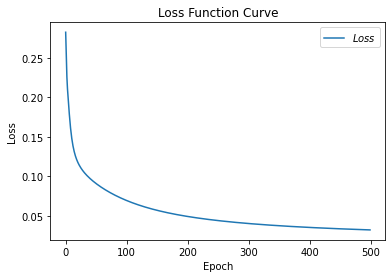

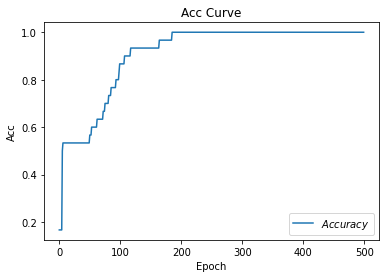

In [15]:
# 训练部分
now_time = time.time()  ##2##
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 每个epoch，打印loss信息
    if epoch % 100 == 0:
        print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
   
    y = tf.matmul(x_test, w1) + b1
    y = tf.nn.softmax(y)
    pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
    # 将pred转换为y_test的数据类型
    pred = tf.cast(pred, dtype=y_test.dtype)
    # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
    correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
    # 将每个batch的correct数加起来
    correct = tf.reduce_sum(correct)
    # 将所有batch中的correct数加起来
    total_correct = int(correct)
    # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
    total_number = x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    if epoch % 100 == 0:
        print("Test_acc:", acc)
        print("--------------------------")
total_time = time.time() - now_time  ##3##
print("total_time", total_time)  ##4##

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

### SDGM

Epoch 0, loss: 0.2961867228150368
Test_acc: 0.16666666666666666
--------------------------
Epoch 100, loss: 0.06580190174281597
Test_acc: 0.9666666666666667
--------------------------
Epoch 200, loss: 0.0467837443575263
Test_acc: 1.0
--------------------------
Epoch 300, loss: 0.03832796635106206
Test_acc: 1.0
--------------------------
Epoch 400, loss: 0.033616107888519764
Test_acc: 1.0
--------------------------
total_time 6.250306606292725


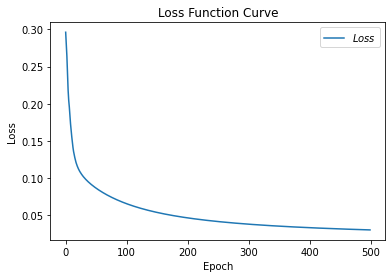

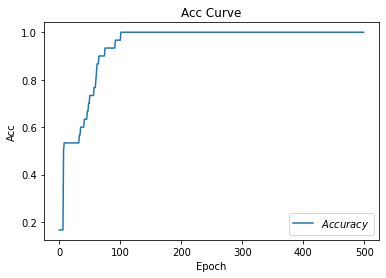

In [16]:
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和
##################################################
m_w, m_b = 0, 0
beta = 0.9
##################################################
# 训练部分
now_time = time.time()  ##2##
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        ##########################################################################
        # sgd-momentun  
        m_w = beta * m_w + (1 - beta) * grads[0]
        m_b = beta * m_b + (1 - beta) * grads[1]
        w1.assign_sub(lr * m_w)
        b1.assign_sub(lr * m_b)
    ##########################################################################

    # 每个epoch，打印loss信息
    if epoch % 100 == 0:
        print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0

    # 使用更新后的参数进行预测
    y = tf.matmul(x_test, w1) + b1
    y = tf.nn.softmax(y)
    pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
    # 将pred转换为y_test的数据类型
    pred = tf.cast(pred, dtype=y_test.dtype)
    # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
    correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
    # 将每个batch的correct数加起来
    correct = tf.reduce_sum(correct)
    # 将所有batch中的correct数加起来
    total_correct = int(correct)
    # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
    total_number = x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    if epoch % 100 == 0:
        print("Test_acc:", acc)
        print("--------------------------")
total_time = time.time() - now_time  ##3##
print("total_time", total_time)  ##4##

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()


### Adagrad

Epoch 0, loss: 0.2528788633644581
Test_acc: 0.5333333333333333
--------------------------
Epoch 100, loss: 0.05753319896757603
Test_acc: 1.0
--------------------------
Epoch 200, loss: 0.04407376889139414
Test_acc: 1.0
--------------------------
Epoch 300, loss: 0.03786272555589676
Test_acc: 1.0
--------------------------
Epoch 400, loss: 0.03418843587860465
Test_acc: 1.0
--------------------------
total_time 7.425151586532593


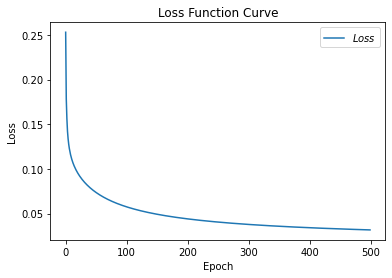

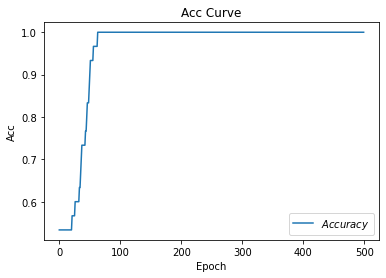

In [17]:
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和
##########################################################################
v_w, v_b = 0, 0
##########################################################################

# 训练部分
now_time = time.time()  ##2##
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        ##########################################################################
        # adagrad
        v_w += tf.square(grads[0])
        v_b += tf.square(grads[1])
        w1.assign_sub(lr * grads[0] / tf.sqrt(v_w))
        b1.assign_sub(lr * grads[1] / tf.sqrt(v_b))
    ##########################################################################

    # 每个epoch，打印loss信息
    if epoch % 100 == 0:
        print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0

    # 使用更新后的参数进行预测
    y = tf.matmul(x_test, w1) + b1
    y = tf.nn.softmax(y)
    pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
    # 将pred转换为y_test的数据类型
    pred = tf.cast(pred, dtype=y_test.dtype)
    # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
    correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
    # 将每个batch的correct数加起来
    correct = tf.reduce_sum(correct)
    # 将所有batch中的correct数加起来
    total_correct = int(correct)
    # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
    total_number = x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    if epoch % 100 == 0:
        print("Test_acc:", acc)
        print("--------------------------")
total_time = time.time() - now_time  ##3##
print("total_time", total_time)  ##4##

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

### rmsprop

Epoch 0, loss: 0.3926014229655266
Test_acc: 0.16666666666666666
--------------------------
Epoch 100, loss: 0.04112491477280855
Test_acc: 1.0
--------------------------
Epoch 200, loss: 0.02897816471522674
Test_acc: 1.0
--------------------------
Epoch 300, loss: 0.02874010434607044
Test_acc: 1.0
--------------------------
Epoch 400, loss: nan
Test_acc: 0.36666666666666664
--------------------------
total_time 8.308799743652344


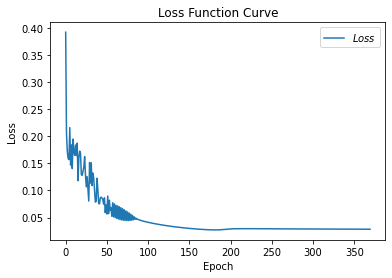

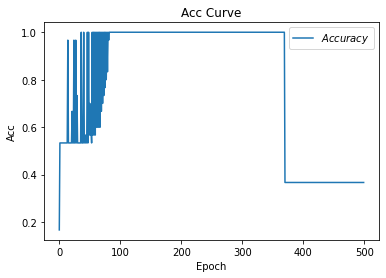

In [18]:
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和
##########################################################################
v_w, v_b = 0, 0
beta = 0.9
##########################################################################

# 训练部分
now_time = time.time()  ##2##
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        ##########################################################################
        # rmsprop
        v_w = beta * v_w + (1 - beta) * tf.square(grads[0])
        v_b = beta * v_b + (1 - beta) * tf.square(grads[1])
        w1.assign_sub(lr * grads[0] / tf.sqrt(v_w))
        b1.assign_sub(lr * grads[1] / tf.sqrt(v_b))
    ##########################################################################

    # 每个epoch，打印loss信息
    if epoch % 100 == 0:
        print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    if epoch % 100 == 0:
        print("Test_acc:", acc)
        print("--------------------------")
total_time = time.time() - now_time  ##3##
print("total_time", total_time)  ##4##

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

### adam

Epoch 0, loss: 0.21984169632196426
Test_acc: 0.5333333333333333
--------------------------
Epoch 100, loss: 0.01909852074459195
Test_acc: 1.0
--------------------------
Epoch 200, loss: 0.01617956580594182
Test_acc: 1.0
--------------------------
Epoch 300, loss: 0.014982119319029152
Test_acc: 1.0
--------------------------
Epoch 400, loss: 0.014330179779790342
Test_acc: 1.0
--------------------------
total_time 7.417313098907471


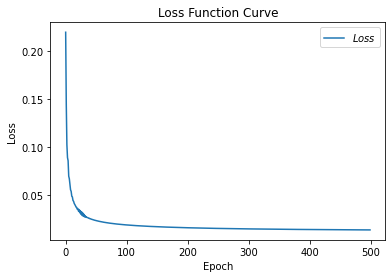

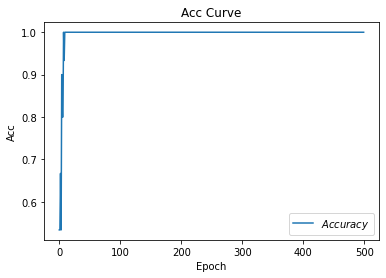

In [19]:
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和
##########################################################################
m_w, m_b = 0, 0
v_w, v_b = 0, 0
beta1, beta2 = 0.9, 0.999
delta_w, delta_b = 0, 0
global_step = 0
##########################################################################

# 训练部分
now_time = time.time()  ##2##
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
 ##########################################################################       
        global_step += 1
 ##########################################################################       
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

##########################################################################
 # adam
        m_w = beta1 * m_w + (1 - beta1) * grads[0]
        m_b = beta1 * m_b + (1 - beta1) * grads[1]
        v_w = beta2 * v_w + (1 - beta2) * tf.square(grads[0])
        v_b = beta2 * v_b + (1 - beta2) * tf.square(grads[1])

        m_w_correction = m_w / (1 - tf.pow(beta1, int(global_step)))
        m_b_correction = m_b / (1 - tf.pow(beta1, int(global_step)))
        v_w_correction = v_w / (1 - tf.pow(beta2, int(global_step)))
        v_b_correction = v_b / (1 - tf.pow(beta2, int(global_step)))

        w1.assign_sub(lr * m_w_correction / tf.sqrt(v_w_correction))
        b1.assign_sub(lr * m_b_correction / tf.sqrt(v_b_correction))
##########################################################################

    # 每个epoch，打印loss信息
    if epoch % 100 == 0:
        print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0

    # 使用更新后的参数进行预测
    y = tf.matmul(x_test, w1) + b1
    y = tf.nn.softmax(y)
    pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
    # 将pred转换为y_test的数据类型
    pred = tf.cast(pred, dtype=y_test.dtype)
    # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
    correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
    # 将每个batch的correct数加起来
    correct = tf.reduce_sum(correct)
    # 将所有batch中的correct数加起来
    total_correct += int(correct)
    # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
    total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    if epoch % 100 == 0:
        print("Test_acc:", acc)
        print("--------------------------")
total_time = time.time() - now_time  ##3##
print("total_time", total_time)  ##4##

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()